In [28]:
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt
import random
import itertools

In [29]:
class TicTacToe:
    def __init__(self,size) :
        self.size = size
        self.board = np.zeros((size,size),dtype=int)
        self.current_player = 1
    
    def available_actions(self):
        return [(i,j) for i in range(self.size) for j in range(self.size) if self.board[i][j] == 0]
    
    def make_move(self,action):
        i,j = action
        if self.board[i,j] == 0:
            self.board[i,j] = self.current_player
            self.current_player = 3 - self.current_player
            return True
        return False
    
    def check_winner(self):
        for player in [1, 2]:
            player_win = player * np.ones(self.size)
            if any(np.all(self.board == player_win, axis=1)) or \
               any(np.all(self.board == player_win, axis=0)) or \
               np.all(np.diag(self.board) == player_win) or \
               np.all(np.diag(np.fliplr(self.board)) == player_win):
                return player
        return None if len(self.available_actions()) > 0 else 0

    
    def is_terminal(self):
        return self.check_winner() is not None
    
    def get_state(self):
        return tuple(self.board.flatten())


In [30]:
def is_valid_state(state):
    return abs(state.count(1) - state.count(2)) <= 1

def all_valid_states(size):
    return (state for state in itertools.product([0, 1, 2], repeat=size*size) if is_valid_state(state))


In [31]:
def is_terminal_state(state):
    # Check if terminal
    board = np.array(state).reshape((int(len(state)**0.5), int(len(state)**0.5)))
    game = TicTacToe(int(len(state)**0.5))
    game.board = board
    return game.is_terminal()

In [32]:
def get_reward(state):
    # Define reward
    board = np.array(state).reshape((int(len(state)**0.5), int(len(state)**0.5)))
    game = TicTacToe(int(len(state)**0.5))
    game.board = board
    winner = game.check_winner()
    if winner == 1:
        return 1
    elif winner == 2:
        return -1
    else:
        return 0

In [33]:
def available_actions(state):
    return list(zip(*np.where(np.array(state).reshape((int(len(state)**0.5), -1)) == 0)))

In [34]:
def q_value(state,action,V, discount_factor):
    # Compute Q_value q(s,a)
    next_state = list(state)
    current_player = 1 if state.count(1) <= state.count(2) else 2
    next_state[action[0] * int(len(state)**0.5) + action[1]] = current_player
    next_state = tuple(next_state)
    return get_reward(next_state) + discount_factor*V[next_state]

In [35]:
def generate_episode(size):
    game = TicTacToe(size)
    episode = []
    while not game.is_terminal():
        state = game.get_state()
        action = random.choice(game.available_actions())
        game.make_move(action)
        reward = get_reward(game.get_state())  # Tính reward sau khi di chuyển
        episode.append((action, state, reward))
    return episode

In [36]:
def initial_state(size):
    # Return first step of game
    return tuple(np.zeros(size*size, dtype='int'))

In [37]:
def step(state, action):
    # Make action and return next state + reward
    next_state = list(state)
    next_state[action[0] * int(len(state)**0.5) + action[1]] = 1
    next_state = tuple(next_state)
    return next_state, get_reward(next_state)

In [38]:
def epsilon_greedy(state, Q, epsilon=0.1):
    # Implement epsilon-greedy
    # if number < episilon -> random else max
    if random.random() < epsilon:
        return random.choice(available_actions(state))
    else:
        return max(available_actions(state), key=lambda a: Q[state][a])

In [39]:
def value_iteration(size, num_iterations=1000, discount_factor=0.7):
    V = defaultdict(float)
    
    for _ in range(num_iterations):
        for state in all_valid_states(size):
            if is_terminal_state(state):
                V[state] = get_reward(state)
            else:
                V[state] = max(q_value(state, action, V, discount_factor)
                               for action in available_actions(state))
    return V

In [40]:
def monte_carlo(size, num_episodes=10000, discount_factor=1.0):
    Q = defaultdict(lambda: defaultdict(float))
    returns_sum = defaultdict(lambda: defaultdict(float))
    returns_count = defaultdict(lambda: defaultdict(int))
    
    for _ in range(num_episodes):
        episode = generate_episode(size)
        G = 0
        for t in range(len(episode) - 1, -1, -1):
            state, action, reward = episode[t]
            G = discount_factor * G + reward
            
            if (state, action) not in [(x[0], x[1]) for x in episode[:t]]:
                returns_sum[state][action] += G
                returns_count[state][action] += 1
                Q[state][action] = returns_sum[state][action] / returns_count[state][action]
    
    return Q

In [41]:
def td_learning(size, num_episodes=10000, alpha=0.1, discount_factor=1.0):
    V = defaultdict(float)
    
    for _ in range(num_episodes):
        state = initial_state(size)
        while not is_terminal_state(state):
            action = epsilon_greedy(state, {s: {a: V[s] for a in available_actions(s)} for s in all_valid_states(size)})
            next_state, reward = step(state, action)
            td_target = reward + discount_factor * V[next_state]
            td_error = td_target - V[state]
            V[state] += alpha * td_error
            state = next_state
    
    return V

In [42]:
def sarsa(size, num_episodes=100000, alpha=0.1, discount_factor=0.99, epsilon_start=1.0, epsilon_end=0.01, epsilon_decay=0.9995):
    Q = defaultdict(lambda: defaultdict(lambda: 1.0))  # Optimistic initialization
    epsilon = epsilon_start

    for episode in range(num_episodes):
        state = initial_state(size)
        action = epsilon_greedy(state, Q, epsilon)
        
        while not is_terminal_state(state):
            next_state, reward = step(state, action)
            
            if is_terminal_state(next_state):
                Q[state][action] += alpha * (reward - Q[state][action])
                break
            
            next_action = epsilon_greedy(next_state, Q, epsilon)
            td_target = reward + discount_factor * Q[next_state][next_action]
            td_error = td_target - Q[state][action]
            Q[state][action] += alpha * td_error
            
            state, action = next_state, next_action
        
        # Epsilon decay
        epsilon = max(epsilon_end, epsilon * epsilon_decay)
    
    return Q

In [43]:
def q_learning(size, num_episodes=100000, alpha=0.1, discount_factor=0.99, epsilon_start=1.0, epsilon_end=0.01, epsilon_decay=0.9995):
    Q = defaultdict(lambda: defaultdict(lambda: 0.0))  # Khởi tạo với giá trị 0
    epsilon = epsilon_start
    
    for episode in range(num_episodes):
        state = initial_state(size)
        while not is_terminal_state(state):
            action = epsilon_greedy(state, Q, epsilon)
            next_state, reward = step(state, action)
            
            max_next_q = max(Q[next_state].values()) if Q[next_state] else 0
            
            td_target = reward + discount_factor * max_next_q
            td_error = td_target - Q[state][action]
            Q[state][action] += alpha * td_error
            
            state = next_state
        
        epsilon = max(epsilon_end, epsilon * epsilon_decay)
    
    return Q

Training for 4x4 board
  Training Q-Learning...
    Win rate: 0.34
  Training SARSA...
    Win rate: 0.30
Training for 5x5 board
  Training Q-Learning...
    Win rate: 0.26
  Training SARSA...
    Win rate: 0.24


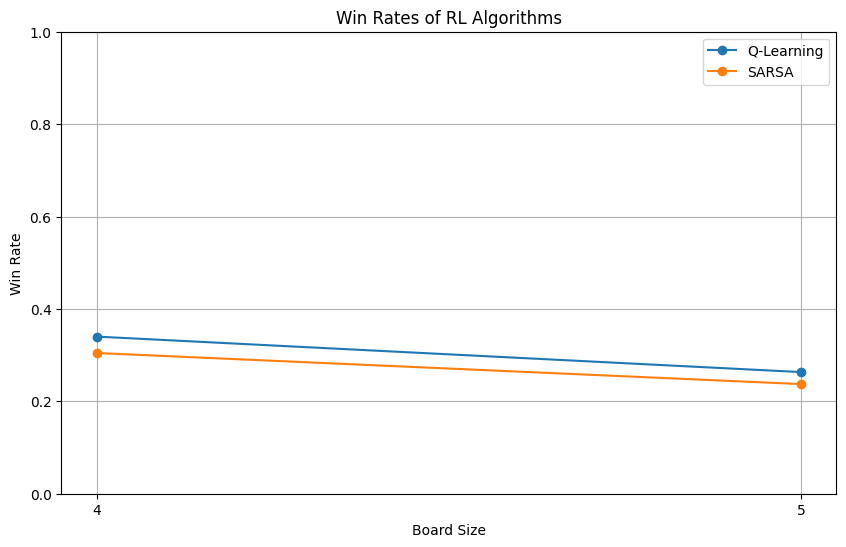

In [44]:
def create_agent(Q):
    def agent(game):
        state = game.get_state()
        return max(Q[state], key=Q[state].get) if state in Q else random.choice(game.available_actions())
    return agent

def evaluate_agent(agent, size, num_games=10000):
    wins = 0
    for _ in range(num_games):
        game = TicTacToe(size)
        while not game.is_terminal():
            if game.current_player == 1:
                action = agent(game)
            else:
                action = random.choice(game.available_actions())
            game.make_move(action)
        if game.check_winner() == 1:
            wins += 1
    return wins / num_games

def plot_win_rates(win_rates):
    plt.figure(figsize=(10, 6))
    for algorithm, rates in win_rates.items():
        plt.plot([4, 5], rates, marker='o', label=algorithm)
    plt.title('Win Rates of RL Algorithms')
    plt.xlabel('Board Size')
    plt.ylabel('Win Rate')
    plt.ylim(0, 1)
    plt.xticks([4, 5])
    plt.legend()
    plt.grid(True)
    plt.show()

if __name__ == "__main__":
    algorithms = {
       # "Value Iteration": value_iteration,
       # "Monte Carlo": monte_carlo,
       # "TD Learning": td_learning,
       "Q-Learning": q_learning,
        "SARSA": sarsa
    }
    
    win_rates = {alg: [] for alg in algorithms}
    
    for size in [4, 5]:
        print(f"Training for {size}x{size} board")
        for alg_name, alg_func in algorithms.items():
            print(f"  Training {alg_name}...")
            Q = alg_func(size)
            agent = create_agent(Q)
            win_rate = evaluate_agent(agent, size)
            win_rates[alg_name].append(win_rate)
            print(f"    Win rate: {win_rate:.2f}")
    
    plot_win_rates(win_rates)